# Proyek Klasifikasi Gambar: [Kaggle Dataset : translated_animals10]
- **Nama:** [Fachreza Riyanda]
- **Email:** [rza984002@gmail.com]
- **ID Dicoding:** [fachrezarynd]

## Import Semua Packages/Library yang Digunakan

In [2]:
import os
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading

In [4]:
animals = os.path.join('/content/drive/MyDrive/Colab Notebooks/animals10/raw-img/')
print(os.listdir(animals))

['butterfly', 'spider', 'cow', 'chicken', 'squirrel', 'dog', 'horse', 'elephant', 'cat', 'sheep']


## Data Preprocessing

In [5]:
ignore_animals = ['squirrel', 'chicken', 'cow', 'spider', 'butterfly', 'horse', 'dog']

for x in ignore_animals:
    path = os.path.join(animals, x)
    shutil.rmtree(path)

In [6]:
list_animals = os.listdir(animals)
print(list_animals)

['elephant', 'cat', 'sheep']


In [7]:
total = 0

for x in list_animals:
    dir = os.path.join(animals, x)
    y = len(os.listdir(dir))
    print(x + ':', y)
    total = total + y

    img_name = os.listdir(dir)
    for z in range(4):
        img_path = os.path.join(dir, img_name[z])
        img = Image.open(img_path)
        print('-', img.size)
    print('---------------')

print('\nTotal :', total)

elephant: 1446
- (300, 170)
- (300, 200)
- (300, 202)
- (300, 218)
---------------
cat: 1668
- (300, 222)
- (300, 200)
- (300, 225)
- (300, 300)
---------------
sheep: 1820
- (300, 200)
- (300, 158)
- (300, 142)
- (300, 225)
---------------

Total : 4934


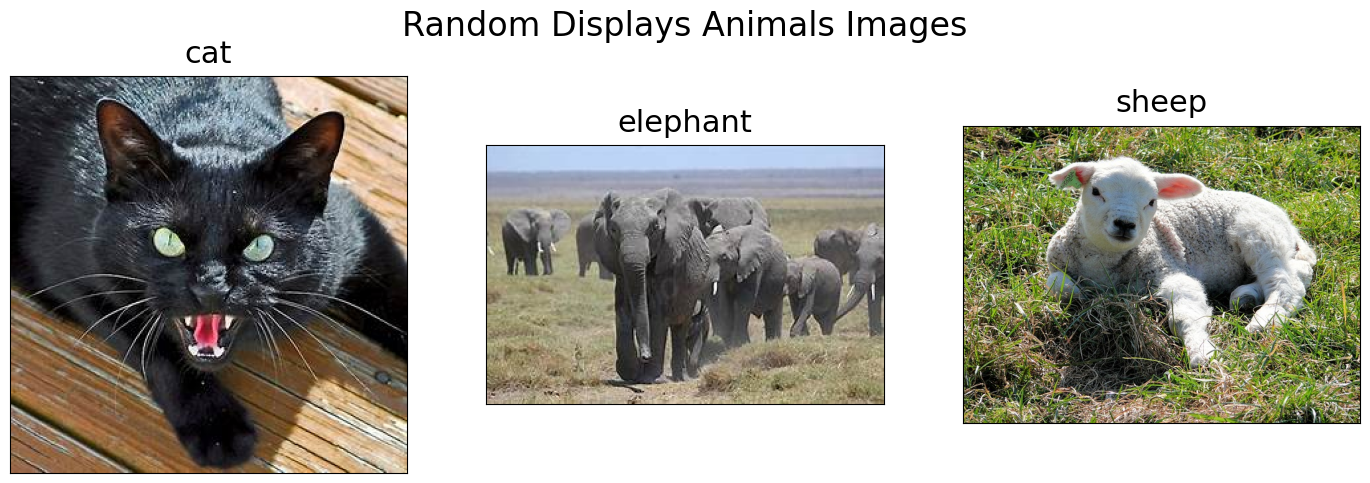

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Random Displays Animals Images", fontsize=24)
animals_sorted = sorted(list_animals)
animals_id = 0

for j in range(3):
    if animals_id >= len(animals_sorted):
        ax[j].axis('off')
        continue
    animals_selected = animals_sorted[animals_id]
    animals_id += 1
    if animals_selected == '.TEMP':
        ax[j].axis('off')
        continue
    animals_selected_images = os.listdir(os.path.join(animals, animals_selected))
    if not animals_selected_images:
        ax[j].axis('off')
        continue
    animals_selected_random = np.random.choice(animals_selected_images)
    img = plt.imread(os.path.join(animals, animals_selected, animals_selected_random))
    ax[j].imshow(img)
    ax[j].set_title(animals_selected, pad=10, fontsize=22)

plt.setp(ax, xticks=[], yticks=[])
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.05, wspace=0.2)
plt.show()

## Modelling

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [10]:
batch_size = 256

data_train = train_datagen.flow_from_directory(
    animals,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 3948 images belonging to 3 classes.


In [11]:
data_val = train_datagen.flow_from_directory(
    animals,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 986 images belonging to 3 classes.


In [12]:
tf.device('/device:GPU:0')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(list_animals), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [13]:
class myCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92:
            print("\nAccuracy above 92%, finish training!")
            self.model.stop_training = True

callbacks = [
    myCallback(),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='model.keras', save_best_only=True)
]


In [17]:
history = model.fit(data_train,
                    epochs=20,
                    steps_per_epoch=data_train.samples // batch_size,
                    validation_data=data_val,
                    validation_steps=data_val.samples // batch_size,
                    verbose=2,
                    callbacks=callbacks)

Epoch 1/20
15/15 - 401s - loss: 0.4712 - accuracy: 0.8077 - val_loss: 0.4741 - val_accuracy: 0.8190 - 401s/epoch - 27s/step
Epoch 2/20
15/15 - 412s - loss: 0.4844 - accuracy: 0.8055 - val_loss: 0.4941 - val_accuracy: 0.7969 - 412s/epoch - 27s/step
Epoch 3/20
15/15 - 397s - loss: 0.4907 - accuracy: 0.8028 - val_loss: 0.4262 - val_accuracy: 0.8307 - 397s/epoch - 26s/step
Epoch 4/20
15/15 - 396s - loss: 0.4383 - accuracy: 0.8313 - val_loss: 0.4142 - val_accuracy: 0.8359 - 396s/epoch - 26s/step
Epoch 5/20
15/15 - 408s - loss: 0.4695 - accuracy: 0.8123 - val_loss: 0.4432 - val_accuracy: 0.8086 - 408s/epoch - 27s/step
Epoch 6/20
15/15 - 398s - loss: 0.4629 - accuracy: 0.8090 - val_loss: 0.4185 - val_accuracy: 0.8333 - 398s/epoch - 27s/step
Epoch 7/20
15/15 - 408s - loss: 0.4196 - accuracy: 0.8267 - val_loss: 0.4433 - val_accuracy: 0.8255 - 408s/epoch - 27s/step
Epoch 8/20
15/15 - 400s - loss: 0.4418 - accuracy: 0.8207 - val_loss: 0.4210 - val_accuracy: 0.8333 - 400s/epoch - 27s/step
Epoch 9/

In [22]:
history2 = model.fit(data_train,
                    epochs=10,
                    steps_per_epoch=data_train.samples // batch_size,
                    validation_data=data_val,
                    validation_steps=data_val.samples // batch_size,
                    verbose=2,
                    callbacks=callbacks)

Epoch 1/10
15/15 - 424s - loss: 0.4031 - accuracy: 0.8388 - val_loss: 0.4221 - val_accuracy: 0.8424 - 424s/epoch - 28s/step
Epoch 2/10
15/15 - 385s - loss: 0.3728 - accuracy: 0.8524 - val_loss: 0.3542 - val_accuracy: 0.8685 - 385s/epoch - 26s/step
Epoch 3/10
15/15 - 392s - loss: 0.3781 - accuracy: 0.8451 - val_loss: 0.3684 - val_accuracy: 0.8659 - 392s/epoch - 26s/step
Epoch 4/10
15/15 - 396s - loss: 0.3513 - accuracy: 0.8648 - val_loss: 0.3586 - val_accuracy: 0.8737 - 396s/epoch - 26s/step
Epoch 5/10
15/15 - 395s - loss: 0.3699 - accuracy: 0.8573 - val_loss: 0.3573 - val_accuracy: 0.8568 - 395s/epoch - 26s/step
Epoch 6/10
15/15 - 406s - loss: 0.3424 - accuracy: 0.8632 - val_loss: 0.3344 - val_accuracy: 0.8620 - 406s/epoch - 27s/step
Epoch 7/10
15/15 - 389s - loss: 0.3519 - accuracy: 0.8602 - val_loss: 0.3598 - val_accuracy: 0.8633 - 389s/epoch - 26s/step
Epoch 8/10
15/15 - 398s - loss: 0.3544 - accuracy: 0.8635 - val_loss: 0.3904 - val_accuracy: 0.8503 - 398s/epoch - 27s/step
Epoch 9/

## Evaluasi dan Visualisasi

In [23]:
combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history2.history[key]

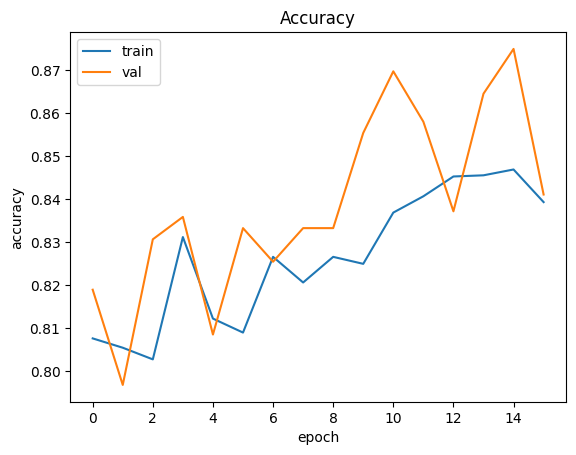

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

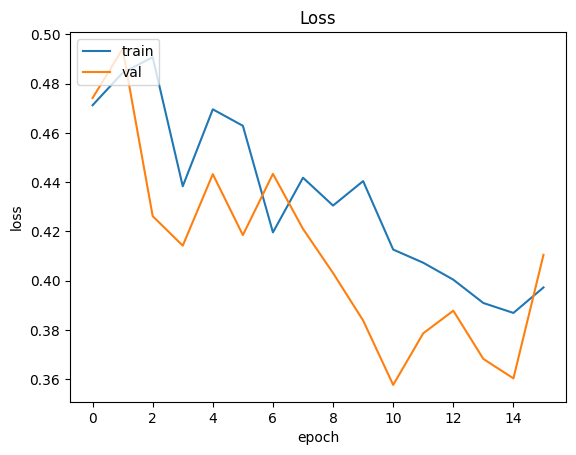

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Konversi Model

In [43]:
model.save('saved_model')
print("Model disimpan dalam format SavedModel")

Model disimpan dalam format SavedModel


In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model dikonversi ke format TF-Lite")

Model dikonversi ke format TF-Lite


In [45]:
model.save('model.h5')
print("Model disimpan dalam format Keras (.h5)")

Model disimpan dalam format Keras (.h5)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6

In [53]:
!tensorflowjs_converter --input_format keras model.h5 tfjs_model/
print("Model dikonversi ke format TensorFlow.js")

2024-07-18 13:43:10.950570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 13:43:11.112505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 13:43:11.112595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 13:43:17.070727: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Model dikonversi ke format TensorFlow.js


## Inference (Optional)

In [54]:
if not os.path.exists('submission'):
    os.mkdir('submission')

if not os.path.exists('submission/tfjs_model'):
    os.makedirs('submission/tfjs_model')

if not os.path.exists('submission/tflite'):
    os.makedirs('submission/tflite')

if not os.path.exists('submission/saved_model'):
    os.makedirs('submission/saved_model')


In [56]:

if os.path.exists('saved_model'):

    if os.path.exists('submission/saved_model'):
        shutil.rmtree('submission/saved_model')
    shutil.copytree('saved_model', 'submission/saved_model')
else:
    print("Direktori 'saved_model' tidak ditemukan.")


if os.path.exists('model.tflite'):
    shutil.move('model.tflite', 'submission/tflite/model.tflite')
else:
    print("File 'model.tflite' tidak ditemukan.")


if os.path.exists('tfjs_model'):

    if os.path.exists('submission/tfjs_model'):
        shutil.rmtree('submission/tfjs_model')
    shutil.copytree('tfjs_model', 'submission/tfjs_model')
else:
    print("Direktori 'tfjs_model' tidak ditemukan.")

In [57]:
shutil.make_archive('submission', 'zip', 'submission')

'/content/submission.zip'

In [58]:
from google.colab import files
files.download('submission.zip') # Download the zip file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
 pip freeze requirements.txt

absl-py==2.1.0
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client==1.11.0
anaconda-navigator==2.3.1
anaconda-project @ file:///C:/Windows/TEMP/abs_91fu4tfkih/croots/recipe/anaconda-project_1660339890874/work
anyio @ file:///C:/ci/anyio_1644481921011/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644551690056/work
arrow @ file:///opt/conda/conda-bld/arrow_1649166651673/work
astroid @ file:///C:/Windows/TEMP/abs_b0dtxgpicv/croots/recipe/astroid_1659023126745/work
astropy @ file:///C:/ci/astropy_1657719656942/work
astunparse==1.6.3
atomicwrites==1.4.0
attrs @ file:///opt/conda/conda-bld/attrs_1642510447205/work
Automat @ file:///tmp/build/80754af9/automat_1600298431173/work
autopep8 @ file:///opt/conda/conda-bld/autopep8_1650463822033/work
Babel @ file:///tmp/build/80754af9/babel_1620871417480/work
backcall @ file:///home/ktietz/src/ci/backcall_161